In [1]:
# Set up environment

import subprocess
import warnings
from io import BytesIO

import folium
import hvplot.pandas
import pandas as pd
import requests

warnings.filterwarnings('ignore')

## Streamflow in Boulder Creek, Boulder, CO remains steady despite 2013 flood

In [2]:
# Site map for Boulder Creek, CO

sg_lat = 40.05165184
sg_lon = -105.1788754

# Initialize map and tweak settings
m = folium.Map(
    # Location to display
    location=(sg_lat, sg_lon),
    # Turns off annoying zooming while trying to scroll to the next cell
    scrollWheelZoom=False)

# Put a marker at the stream gauge location
folium.Marker([sg_lat, sg_lon], popup="Stream Gauge on the Boulder Creek"
               "in Boulder, CO").add_to(m)

# Display the map
# m

In [3]:
# Read url

nwis_url = (
    "https://waterdata.usgs.gov/nwis/dv"
    "?cb_00060=on"
    "&format=rdb"
    "&site_no=06730200"
    "&legacy="
    "&referred_module=sw"
    "&period="
    "&begin_date=1985-10-01"
    "&end_date=2022-09-30")

# Send an HTTP GET request to the URL
nwis_response = requests.get(nwis_url)
nwis_response.raise_for_status()

In [4]:
# Import data with pandas

co_q_df = pd.read_csv(
    BytesIO(nwis_response.content),
    comment="#",
    delimiter="\t",
    skiprows=[27, 28],
    names=["agency_cd", "site_no", "datetime", "streamflow_cfs", "code"],
    index_col="datetime",
    parse_dates=True,
)

In [5]:
# replace dataframe

# co_q_df.info()

In [6]:
#plot data for specific time period

co_flood_df = co_q_df['2012-10':'2014-09']


### Streamflow in Boulder Creek, Boulder, CO from 2012-2014

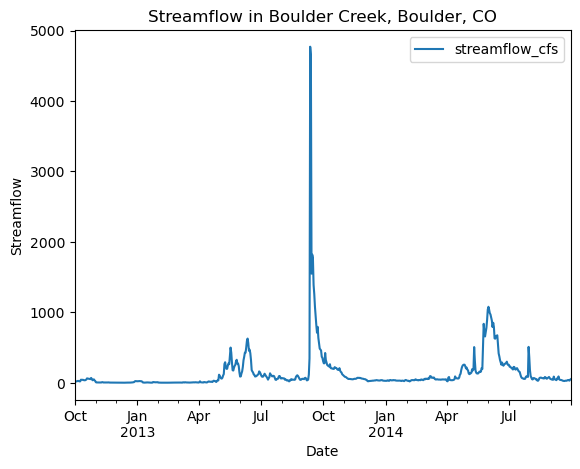

In [7]:
# plot from 2018-2020

co_flood_df.plot(
    y='streamflow_cfs',
    title='Streamflow in Boulder Creek, Boulder, CO',
    xlabel='Date', ylabel='Streamflow');

### Total streamflow from 1986-2023

In [8]:
# plot total streamflow over time

# co_q_df.streamflow_cfs.plot();

In [9]:
# resample

co_ann_max_q_df = co_q_df[['streamflow_cfs']].resample('AS').max()


### Maximum streamflow from 1986-2023

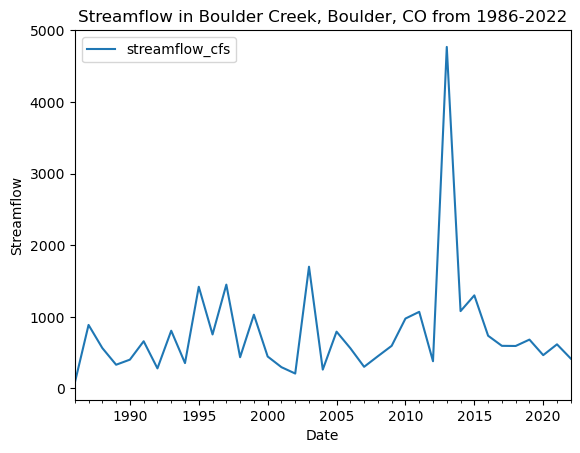

In [10]:
# plot resampled data

co_ann_max_q_df.plot(
    title='Streamflow in Boulder Creek, Boulder, CO from 1986-2022',
    xlabel='Date', ylabel='Streamflow'
);

### Data Source

Data retrieved from [USGS NWIS](https://maps.waterdata.usgs.gov/mapper/index.html).

In [11]:
%%capture
%%bash
jupyter nbconvert bouldercreek-timeseries.ipynb --to html --no-input